Constantes: tamanho do Mock e instância do Faker

In [1]:
from faker import Faker
USER_COUNT = 406028
TRANSFER_COUNT = 406028 * 2
fake = Faker()

# Dados de Usuário

Iremos gerar um DataFrame Pandas para conter informações de usuário, assim como o endereço do mesmo.

In [2]:
import pandas as pd

users = pd.DataFrame({
    'id': [fake.uuid4() for _ in range(USER_COUNT)],
    'created_at': None,
    'birthday': None,
    'city': None,
    'state': None,
    'country': None
})
display(users)

,id,created_at,birthday,city,state,country
0,2af2a1f3-89d1-49b2-acff-2d8d702dc517,None,None,None,None,None
1,06148a83-b0ae-4400-b82c-0a12545e89cf,None,None,None,None,None
2,1d5af7c3-29c8-493f-a83d-386b94f89bd3,None,None,None,None,None
3,36e20419-7518-42a8-ae1d-71b7a44aec29,None,None,None,None,None
4,3a6ea8bf-5116-4f9a-b29d-15119f030272,None,None,None,None,None
...,...,...,...,...,...,...
406023,7ca38107-b9a1-4a81-a51f-80cbfafef000,None,None,None,None,None
406024,68e4c30c-a244-4ca3-aa03-8d1528b39049,None,None,None,None,None
406025,65ea6f11-7a18-4c8c-9e6e-4bd99952af53,None,None,None,None,None
406026,9895f0a2-cd2e-41b6-8494-58710958e889,None,None,None,None,None


Gerando *created_at* (omitindo *updated_at* pois ele não aparece em nenhum lugar do relatório)

Utilizando distribuição ponderada, priorizando os meses 2, 3 e 4.

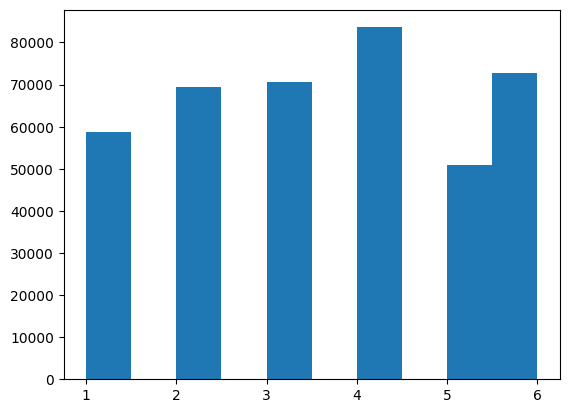

In [3]:
import numpy as np
from matplotlib import pyplot as plt

available_months = np.array([1, 2, 3, 4, 5, 6])
weights_months = np.array([1/6, 1/5, 1/5, 1/4, 1/7, 1/5])
weights_months = weights_months + np.random.normal(0, 0.0125, size=weights_months.shape)
weights_months = weights_months / np.sum(weights_months)
months = np.random.choice(available_months, p=weights_months, size=USER_COUNT)
month_counts = np.bincount(months)[1:]
accumulated_month_counts = np.cumsum(month_counts)
plt.hist(months)
plt.show()

Utilizando distribuição ponderada, priorizando dias iniciais do mês

In [4]:
import numpy as np

available_days = np.array(np.arange(1, 32, dtype=np.int32))
weights_days = np.array([1/10] * 10 + [1/i for i in range(11, 27)] + [1/17] * 5)
weights_days = weights_days + np.random.normal(0, 0.01, size=weights_days.shape)
weights_days = weights_days / np.sum(weights_days)
gen_random_days = lambda size: np.random.choice(available_days, p=weights_days, size=size)

Horas não são aleatórias: priorizar horários de pico

In [5]:
import numpy as np
from scipy.stats import skewnorm

def gen_random_minutes(size):
    minutes = skewnorm.rvs(a=-0.5,loc=960, scale=240, size=size)
    while True:
        minutes = np.round(minutes, 0).astype(int)
        minutes_outside_interval = np.argwhere((minutes < 0) | (minutes >= 1440)).flatten()
        if (minutes_outside_interval.size == 0):
            break
        minutes[minutes_outside_interval] = skewnorm.rvs(a=-0.5,loc=960, scale=240, size=len(minutes_outside_interval))
    return minutes

minutes = gen_random_minutes(USER_COUNT)
hours = minutes // 60
minutes = minutes % 60

Adicionando created_at

In [6]:
from datetime import datetime
import calendar

current_idx = 0
for month, user_count_month in zip(available_months, month_counts):
    _, day_end = calendar.monthrange(2023, month)
    random_days = gen_random_days(user_count_month)
    while True:
        outside_interval = np.argwhere(random_days > day_end).flatten()
        if (outside_interval.size == 0):
            break
        random_days[outside_interval] = gen_random_days(len(outside_interval))
    c_at_array = np.empty((user_count_month,), dtype=object)
    for i in range(user_count_month):
        day_start = datetime(2023, month, random_days[i], hours[current_idx], minutes[current_idx], 0)
        day_end = datetime(2023, month, random_days[i], 23, 59, 59)
        c_at = fake.date_time_between(start_date=day_start, end_date=day_end)
        c_at_array[i] = c_at.isoformat()
    pd_idx = users.index[current_idx:current_idx+user_count_month]
    users.loc[pd_idx, 'created_at'] = c_at_array
    current_idx += user_count_month

Gerando datas de nascimento

Ano será escolhido através de uma distribuição que prioriza fim dos anos 90 e anos 2000

Ano mínimo: 1964
Ano máximo: 2005


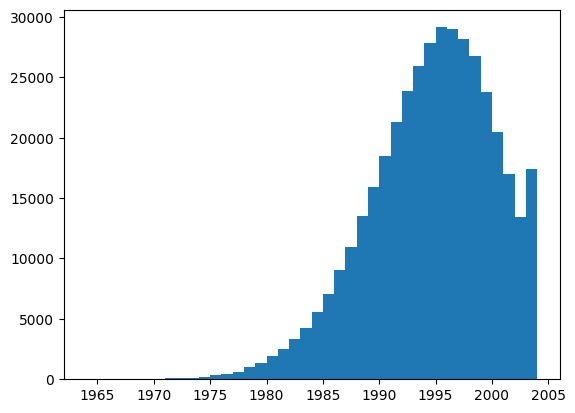

In [7]:
from matplotlib import pyplot as plt
from scipy.stats import skewnorm

alpha = -1.7
loc = 2000
scale = 8
random_years = skewnorm.rvs(a=alpha,loc=loc, scale=scale, size=USER_COUNT)
while True:
  random_years = np.round(random_years, 0).astype(int)
  outside_interval = np.argwhere(random_years > 2005).flatten()
  if (outside_interval.size == 0):
    break
  random_years[outside_interval] = skewnorm.rvs(a=alpha,loc=loc, scale=scale, size=len(outside_interval))
# Count the number of users created in each year
# Year is x axis, count is y axis
minimum_year = np.min(random_years)
maximum_year = np.max(random_years)
print(f'Ano mínimo: {minimum_year}')
print(f'Ano máximo: {maximum_year}')
plt.hist(random_years, bins=range(minimum_year, maximum_year))
plt.show()

Mês e dia são completamente randômicos, utiliza distribuição uniforme

In [8]:
random_dates_with_year = np.empty((USER_COUNT,), dtype=object)
for i in range(USER_COUNT):
    year = random_years[i]
    lower_bound = datetime(year, 1, 1)
    upper_bound = datetime(year, 12, 31)
    random_date = fake.date_between(start_date=lower_bound, end_date=upper_bound).strftime('%Y-%m-%d')
    random_dates_with_year[i] = random_date
users['birthday'] = random_dates_with_year

Ordenando DataFrame de forma que created_at seja crescente

In [9]:
users = users.sort_values(by='created_at')
users = users.reset_index(drop=True)
display(users)

,id,created_at,birthday,city,state,country
0,68b28f79-ab1d-4312-836a-686c2affe388,2023-01-01T17:27:02,1993-12-21,None,None,None
1,0793f1e9-379f-4091-9634-5b71ffaab237,2023-01-01T17:27:11,1993-11-02,None,None,None
2,0d81573e-aed1-4f49-b0f1-3017e28569c1,2023-01-01T17:27:16,1997-07-01,None,None,None
3,a9328547-7454-4bc6-bb61-32c05eb7f65a,2023-01-01T17:27:37,1998-10-30,None,None,None
4,4bbc5350-89d4-4003-815f-1847c0e3fc0a,2023-01-01T17:27:42,2001-02-02,None,None,None
...,...,...,...,...,...,...
406023,8ac5d3a4-b4e9-4660-8e59-a925c11ef63a,2023-06-30T23:58:53,1995-08-23,None,None,None
406024,3bbaedb0-1c1d-4a70-8407-c2218662478f,2023-06-30T23:59:24,1992-02-21,None,None,None
406025,b83d9810-e625-4238-81f0-c69038ce40b4,2023-06-30T23:59:29,1991-08-16,None,None,None
406026,377aabe5-6c0f-44b6-91db-412d6fb059ad,2023-06-30T23:59:44,1997-05-17,None,None,None


# Endereços

Queremos mudar a distribuição de endereços com base na data do onboarding. Portanto, é interessante antes criar uma função que recebe alguns parâmetros, como:
- Importância da população para decidir a cidade
- Presença de cidades fora do Brasil?
- etc

## Cidades do Brasil

Utilizando .csv de municipios contidos [aqui](http://blog.mds.gov.br/redesuas/wp-content/uploads/2018/06/Lista_Munic%C3%ADpios_com_IBGE_Brasil_Versao_CSV.csv)

In [10]:
# Renomeie o CSV
municipios = pd.read_csv('municipios.csv', sep=';')
# Ignorando duas colunas
municipios = municipios.drop(columns=['ConcatUF+Mun', 'Unnamed: 9']).sort_values(by=['População 2010'], ascending=False)
# Ignorando munícipios sem informação de população
municipios = municipios.dropna(subset=['População 2010'])
municipios = municipios.reset_index(drop=True)
display(municipios.head(5))
# Transformando Presidente Prudente em uma cidade com 2M de habitantes
# Só pelo lulz
municipios.loc[municipios['Município'] == 'Presidente Prudente', 'População 2010'] = 2000000
display(municipios[municipios['Município'] == 'Presidente Prudente'])

,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
0,355030,3550308,SP,São Paulo,Região Sudeste,11253503.0,Metrópole,Capital
1,330455,3304557,RJ,Rio de Janeiro,Região Sudeste,6320446.0,Metrópole,Capital
2,292740,2927408,BA,Salvador,Região Nordeste,2675656.0,Metrópole,Capital
3,530010,5300108,DF,Brasília,Região Centro-Oeste,2570160.0,Metrópole,Capital
4,230440,2304400,CE,Fortaleza,Região Nordeste,2452185.0,Metrópole,Capital


,IBGE,IBGE7,UF,Município,Região,População 2010,Porte,Capital
125,354140,3541406,SP,Presidente Prudente,Região Sudeste,2000000.0,Grande,NaN


## Cidades fora do Brasil

Utilizando csv que pode ser encontrado [aqui](https://simplemaps.com/static/data/world-cities/basic/simplemaps_worldcities_basicv1.76.zip)

In [11]:
world_cities = pd.read_csv('worldcities.csv')
# Ignorando cidades sem dados populacionais
world_cities = world_cities.dropna(subset=['population'])
# Ignorando cidades brasileiras
world_cities = world_cities[world_cities['country'] != 'Brazil']
world_cities = world_cities.reset_index(drop=True)
display(world_cities.head(5))

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629


Países da América Latina

In [12]:
latin_america_countries = [
    'Argentina',
    'Bolivia',
    'Chile',
    'Colombia',
    'Ecuador',
    'Paraguay',
    'Peru',
    'Uruguay'
]

Finalmente, preparando a função

In [13]:
def generate_random_cities(size, population_importance=1.6, non_brazilian_percent=0.0, latin_america_importance = 10.0):
    brazilian_percent = 1.0 - non_brazilian_percent
    brazilian_size = int(size * brazilian_percent)
    non_brazilian_size = size - brazilian_size
    cities = pd.DataFrame(columns=['city', 'state', 'country'])
    # Cidades brasileiras
    brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    brazilian_population_power = np.power(municipios['População 2010'], population_importance)
    brazilian_population_weights = brazilian_population_power / np.sum(brazilian_population_power)
    brazilian_cities_idx = np.random.choice(municipios.index, p=brazilian_population_weights, size=brazilian_size)
    brazilian_cities['city'] = municipios.loc[brazilian_cities_idx, 'Município'].values
    brazilian_cities['state'] = municipios.loc[brazilian_cities_idx, 'UF'].values
    brazilian_cities['country'] = 'Brazil'
    # Cidades não brasileiras
    non_brazilian_cities = pd.DataFrame(columns=['city', 'state', 'country'])
    non_brazilian_population_power = np.power(world_cities['population'], population_importance)
    latin_american_countries_idx = world_cities['country'].isin(latin_america_countries)
    non_brazilian_population_power[latin_american_countries_idx] = np.power(non_brazilian_population_power[latin_american_countries_idx], latin_america_importance)
    non_brazilian_population_weights = non_brazilian_population_power / np.sum(non_brazilian_population_power)
    non_brazilian_cities_idx = np.random.choice(world_cities.index, p=non_brazilian_population_weights, size=non_brazilian_size)
    non_brazilian_cities['city'] = world_cities.loc[non_brazilian_cities_idx, 'city'].values
    non_brazilian_cities['state'] = ''
    non_brazilian_cities['country'] = world_cities.loc[non_brazilian_cities_idx, 'country'].values
    # Concatenando
    cities = pd.concat([brazilian_cities, non_brazilian_cities])
    cities = cities.reset_index(drop=True)
    return cities

Primeiros 2 meses: focar em capitais do Brasil

In [14]:
start_idx = 0
end_idx = accumulated_month_counts[1]
count = end_idx - start_idx
cities = generate_random_cities(count, population_importance=2.5)
users.loc[users.index[start_idx: end_idx], ['city', 'state', 'country']] = cities.values

2 próximos meses: cidades brasileiras com menor população

In [15]:
start_idx = accumulated_month_counts[1]
end_idx = accumulated_month_counts[3]
count = end_idx - start_idx
cities = generate_random_cities(count, population_importance=1.5)
users.loc[users.index[start_idx: end_idx], ['city', 'state', 'country']] = cities.values

2 últimos meses: cidades no exterior

In [16]:
start_idx = accumulated_month_counts[3]
end_idx = accumulated_month_counts[-1]
count = end_idx - start_idx
cities = generate_random_cities(count, population_importance=1.0, non_brazilian_percent=0.15, latin_america_importance=4.0)
users.loc[users.index[start_idx: end_idx], ['city', 'state', 'country']] = cities.values

Resultado final

In [17]:
display(users['country'].value_counts())
display(users['state'].value_counts())
display(users['city'].value_counts())


country
Brazil       387499
Argentina     14879
Peru           2186
Colombia        896
Chile           510
Bolivia          44
Ecuador          12
Uruguay           2
Name: count, dtype: int64

state
SP    176398
RJ     54144
MG     22680
       18529
BA     18378
CE     12571
PR     11959
RS     11389
PE     10273
PA      8655
DF      8105
GO      6998
MA      6297
AM      5830
SC      5638
PB      3521
ES      3512
AL      3386
RN      3182
PI      2957
MT      2743
MS      2582
SE      1982
RO      1360
TO      1073
AP       731
AC       726
RR       429
Name: count, dtype: int64

city
São Paulo             137847
Rio de Janeiro         42111
Buenos Aires           14880
Salvador                8841
Brasília                8105
                       ...  
Faria Lemos                1
Adelândia                  1
Pedrinhas Paulista         1
Harmonia                   1
Rosario                    1
Name: count, Length: 5090, dtype: int64

# Salvando dados de usuário em CSV


In [18]:
users.to_csv('users.csv', index=False)

# Transferências

Nesse caso, não incluiremos ID de conta. Referenciaremos diretamente o usuário dono da conta.

In [19]:
transfers = pd.DataFrame(columns=['user_id', 'time', 'scheduled_time', 'amount', 'status'])

## Função que gera transferências com determinada distribuição de valores e horas

In [60]:
from datetime import timedelta
from tqdm import tqdm

def generate_transfers(user_ids, transfer_quantity, loc=50, scale=25, num_outliers=0):
    transfers = pd.DataFrame(columns=['id_from', 'id_to', 'hour', 'minute', 'scheduled_date', 'value', 'status'])
    ids_from, ids_to = user_ids
    total_size = transfer_quantity
    values = np.random.normal(loc=loc, scale=scale, size=total_size - num_outliers)
    values = np.append(values, np.random.normal(loc=3000, scale=1000, size=num_outliers))
    values = np.abs(values)
    values = np.round(values, 2)
    status = np.random.choice(
        ['FAILED', 'DONE', 'SCHEDULED'], p=[0.001, 0.6, 0.399], size=total_size)
    # Chose random ids
    transfers_ids_from = np.random.choice(ids_from, size=total_size)
    transfers_ids_to = np.random.choice(ids_to, size=total_size)
    transfers['id_from'] = transfers_ids_from
    transfers['id_to'] = transfers_ids_to
    transfers['value'] = values
    transfers['status'] = status
    # Horário das transferências
    minutes = gen_random_minutes(total_size)
    hours = minutes // 60
    minutes = minutes % 60
    transfers['hour'] = hours
    transfers['minute'] = minutes
    return transfers


def decide_transfers_dates(transfers):
    users_created_at = users[['id', 'created_at']]
    transfer_with_user_info = pd.merge(transfers, users_created_at, left_on='id_from', right_on='id', how='inner').drop('id', axis=1)
    transfer_with_user_info = pd.merge(transfer_with_user_info, users_created_at, left_on='id_to', right_on='id',  how='inner').drop('id', axis=1)
    transfer_with_user_info['lower_bound'] = transfer_with_user_info.apply(
        lambda row: max(row['created_at_x'], row['created_at_y']), axis=1)
    display(transfer_with_user_info)
    transfer_with_user_info = transfer_with_user_info.drop(['created_at_x', 'created_at_y'], axis=1)
    display(transfer_with_user_info)

In [21]:
# age -> date arithmetic
ages = []
for idx, user in users.iterrows():
    birthday = datetime.fromisoformat(user['birthday'])
    difference = datetime.now() - birthday
    age = difference.days // 365
    ages.append(age)
users['age'] = ages
display(users)

,id,created_at,birthday,city,state,country,age
0,68b28f79-ab1d-4312-836a-686c2affe388,2023-01-01T17:27:02,1993-12-21,São Paulo,SP,Brazil,29
1,0793f1e9-379f-4091-9634-5b71ffaab237,2023-01-01T17:27:11,1993-11-02,Rio de Janeiro,RJ,Brazil,29
2,0d81573e-aed1-4f49-b0f1-3017e28569c1,2023-01-01T17:27:16,1997-07-01,São Paulo,SP,Brazil,26
3,a9328547-7454-4bc6-bb61-32c05eb7f65a,2023-01-01T17:27:37,1998-10-30,Rio de Janeiro,RJ,Brazil,24
4,4bbc5350-89d4-4003-815f-1847c0e3fc0a,2023-01-01T17:27:42,2001-02-02,Brasília,DF,Brazil,22
...,...,...,...,...,...,...,...
406023,8ac5d3a4-b4e9-4660-8e59-a925c11ef63a,2023-06-30T23:58:53,1995-08-23,Buenos Aires,,Argentina,27
406024,3bbaedb0-1c1d-4a70-8407-c2218662478f,2023-06-30T23:59:24,1992-02-21,Bogotá,,Colombia,31
406025,b83d9810-e625-4238-81f0-c69038ce40b4,2023-06-30T23:59:29,1991-08-16,Buenos Aires,,Argentina,31
406026,377aabe5-6c0f-44b6-91db-412d6fb059ad,2023-06-30T23:59:44,1997-05-17,Buenos Aires,,Argentina,26


Usuários na faixa de 18-25: valores mais baixos

In [40]:
user_sample = users['age'].between(18, 25)
sample_size = user_sample.count()
active_size = int(0.9 * sample_size)
active_users_ids = np.random.choice(users[user_sample]['id'], size=active_size)
transfers_amount = int(10 + 26 * np.random.rand()) * sample_size
transfers = generate_transfers(
    (active_users_ids, users['id']), 3, loc=30, scale=10, num_outliers=0)

In [61]:
decide_transfers_dates(transfers)

,id_from,id_to,hour,minute,scheduled_date,value,status,created_at_x,created_at_y,lower_bound
0,7416e4a6-c5c8-403e-8132-5367284e4e8f,4af7c296-2904-445d-80f6-a7bbcf9c2ae1,9,47,NaN,16.38,SCHEDULED,2023-05-09T16:23:32,2023-04-07T16:32:07,2023-05-09T16:23:32
1,38f1d859-5a75-416d-9e97-283b0c7b6b14,9af89caa-3036-4c76-8583-a64ce30e60b9,15,13,NaN,36.33,DONE,2023-02-08T19:21:14,2023-06-01T20:46:29,2023-06-01T20:46:29
2,a105844a-3a59-49d1-8dcc-51b9eea9e3dc,3ee45b34-3d01-46e8-b57b-d446225ef4f3,19,17,NaN,43.49,DONE,2023-04-10T15:29:48,2023-04-05T19:41:56,2023-04-10T15:29:48


,id_from,id_to,hour,minute,scheduled_date,value,status,lower_bound
0,7416e4a6-c5c8-403e-8132-5367284e4e8f,4af7c296-2904-445d-80f6-a7bbcf9c2ae1,9,47,NaN,16.38,SCHEDULED,2023-05-09T16:23:32
1,38f1d859-5a75-416d-9e97-283b0c7b6b14,9af89caa-3036-4c76-8583-a64ce30e60b9,15,13,NaN,36.33,DONE,2023-06-01T20:46:29
2,a105844a-3a59-49d1-8dcc-51b9eea9e3dc,3ee45b34-3d01-46e8-b57b-d446225ef4f3,19,17,NaN,43.49,DONE,2023-04-10T15:29:48


Usuários na faixa de 26-60: valores mais altos

Usuários na faixa de 60+: valores mais baixos